In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants

mm = 1E-3
C = scipy.constants.c

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

def padortruncate(array, dx, dy, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    nx = max((dx-array.shape[1])//2, 0)
    ny = max((dy-array.shape[0])//2, 0)
    px = max((array.shape[1]-dx)//2, 0)
    py = max((array.shape[0]-dy)//2, 0)
    newarray = val_bg * np.ones((dy, dx), dtype=array.dtype)
    cx = min(array.shape[1], dx)
    cy = min(array.shape[0], dy)
    newarray[ny:ny+cy, nx:nx+cx] = array[py:py+cy, px:px+cx]

    return newarray

def fft_resample(img, height, width):
    '''
    Resamples image img by padding or truncating in the Fourier domain.

    '''
    img = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(img)))
    scal = img.size
    img = padortruncate(img, height, width)
    scal = img.size / scal
    img = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img)))*scal

    return img

def G(k, R):
    return np.exp(-1j*k*R)/R

### Load data & antenna coordinates

NOTES:
13 metal spheres in triangular patter, with varying spacing.


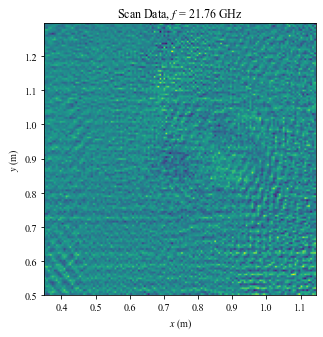

In [2]:
d_antennas = .035        # distance between tx/rx antennas
fc = 22E9
bw = .5E9

mat = scipy.io.loadmat(r'..\..\..\Data\resolution_target_2022-11-01.mat')
notes = list(mat['notes'])
print('NOTES:')
for i in range(len(notes)):
        print(notes[i])
f = mat['f'][0,:]
f_indx = np.argwhere(np.abs(f-fc)<=bw/2)[:,0]
f = f[f_indx]
lam = C/f
k = 2*np.pi/lam
Xa = np.flip(mat['X']*mm, axis=(0,1))   # flipping to recover right-handed coordinate systems
Ya = np.flip(mat['Y']*mm, axis=(0,1))       # flipping because origin of scan stage was at top left
Za = np.zeros_like(Xa)
xa = np.unique(Xa)
ya = np.unique(Ya)
delta_xa = xa[1] - xa[0]
delta_ya = ya[1] - ya[0]
measurements = np.flip(mat['measurements'], axis=(0,1))
measurements = measurements[:,:,f_indx]
z_offset = mat['z_offset'][0,0]*mm

### load background
mat = scipy.io.loadmat(r'..\..\..\Data\Wall_test_background_2022-10-29.mat')
bg = np.flip(mat['measurements'], axis=(0,1))
bg = bg[:,:,f_indx]

### subtract background from measurements
measurements = measurements - bg

set_font(fontsize=15)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.real(measurements[:,:,0]),
           extent=(np.amin(xa), np.amax(xa), np.amin(ya), np.amax(ya)),
           origin='lower')
plt.title('Scan Data, $f$ = {} GHz'.format(f[0]*1E-9))
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.show()

### truncate scan
Lxa_new = 0.4
Lya_new = 0.4

indx_center_x = xa.size//2
indx_center_y = ya.size//2

Xa = Xa[int(indx_center_y-Lya_new//(2*delta_ya)):int((indx_center_y+Lya_new//(2*delta_ya))),
        int(indx_center_x-Lxa_new//(2*delta_xa)):int((indx_center_x+Lxa_new//(2*delta_xa)))]
Ya = Ya[int(indx_center_y-Lya_new//(2*delta_ya)):int((indx_center_y+Lya_new//(2*delta_ya))),
        int(indx_center_x-Lxa_new//(2*delta_xa)):int((indx_center_x+Lxa_new//(2*delta_xa)))]
Za = np.zeros_like(Xa)
measurements = measurements[int(indx_center_y-Lya_new//(2*delta_ya)):int((indx_center_y+Lya_new//(2*delta_ya))),
                            int(indx_center_x-Lxa_new//(2*delta_xa)):int((indx_center_x+Lxa_new//(2*delta_xa))),
                            :]

xa_center = np.mean(Xa)
ya_center = np.mean(Ya)

Na = Xa.size
Nf = f.size
M = Na*Nf                           # total number of measurements
Lxa = np.amax(Xa) - np.amin(Xa)
Lya = np.amax(Ya) - np.amin(Ya)

g = np.reshape(measurements, (M, 1))

### Create H matrix

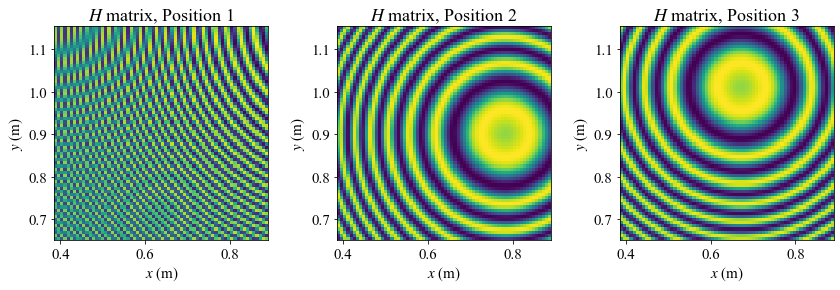

In [3]:
Lxs = .5
Lys = .5
Lzs = .00001

# xs_center = xa_center
# ys_center = ya_center
xs_center = .636
ys_center = .9

cr_res_x = np.amin(lam)*z_offset/(2*Lxa)
cr_res_y = np.amin(lam)*z_offset/(2*Lya)
r_res_z = C/bw

delta_xs = cr_res_x/2
delta_ys = cr_res_y/2
delta_zs = r_res_z/2

xs = np.arange(xs_center-Lxs/2, xs_center+Lxs/2+delta_xs, delta_xs)
ys = np.arange(ys_center-Lys/2, ys_center+Lys/2+delta_ys, delta_ys)
zs = np.arange(z_offset-Lzs/2, z_offset+Lzs/2+delta_zs, delta_zs)
Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='ij')

N = Xs.size                     # total number of scene positions

Xa1, Xs1 = np.meshgrid(Xa.flatten(), Xs.flatten(), indexing='ij')
Ya1, Ys1 = np.meshgrid(Ya.flatten(), Ys.flatten(), indexing='ij')
Za1, Zs1 = np.meshgrid(Za.flatten(), Zs.flatten(), indexing='ij')

Rt = np.sqrt((Xa1 + d_antennas/2 - Xs1)**2 + (Ya1 - Ys1)**2 + (Za1 - Zs1)**2)       # set of transmitter-scene distances
Rr = np.sqrt((Xa1 - d_antennas/2 - Xs1)**2 + (Ya1 - Ys1)**2 + (Za1 - Zs1)**2)       # set of receiver-scene distances

H = np.empty((Na, N, Nf), dtype=np.complex64)
for kk in range(k.size):
    H[:,:,kk] = G(k[kk], Rt) * G(k[kk], Rr)

set_font(fontsize=15)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(float(1)/float(3)))
ax1.imshow(np.real(H[:,10,0]).reshape(Xa.shape), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower')
ax1.set_title('$H$ matrix, Position 1')
ax1.set_xlabel('$x$ (m)')
ax1.set_ylabel('$y$ (m)')
ax2.imshow(np.real(H[:,H.shape[1]//2,0]).reshape(Xa.shape), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower')
ax2.set_title('$H$ matrix, Position 2')
ax2.set_xlabel('$x$ (m)')
ax2.set_ylabel('$y$ (m)')
ax3.imshow(np.real(H[:,2*H.shape[1]//3,0]).reshape(Xa.shape), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower')
ax3.set_title('$H$ matrix, Position 3')
ax3.set_xlabel('$x$ (m)')
ax3.set_ylabel('$y$ (m)')
plt.tight_layout()
plt.show()

H = np.reshape(np.transpose(H, (0, 2, 1)), (M, N))

### Reconstruct

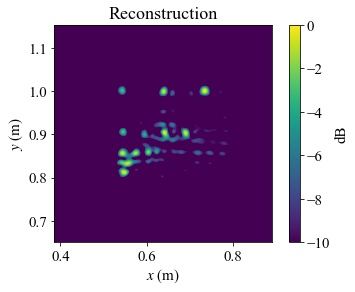

In [4]:
im = np.transpose((np.transpose(np.conjugate(H)) @ g).reshape(Xs.shape), (1, 0, 2))
im = np.abs(np.mean(im, 2))**2

N_interp = 3
im_interpolate = np.abs(fft_resample(im, N_interp*im.shape[0], N_interp*im.shape[1]))
im_interpolate = 10*np.log10(im_interpolate/np.amax(im_interpolate))

set_font(fontsize=15)
plt.figure()
plt.imshow(im_interpolate,
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower')
plt.clim(-10, 0)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()

In [6]:
%matplotlib qt
set_font(fontsize=15)
plt.figure()
plt.imshow(np.flipud(im_interpolate),
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower')
plt.clim(-10, 0)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()